In [1]:
%load_ext autoreload
%autoreload 2

# Figure 3 (General example results)

In [2]:
experiment_ids = 'f1'
timepoints = 'all'
regions = 'cusanovich_dm6_peaks_1kb'
correction = 'wasp'

In [3]:
label = '_'.join([experiment_ids, timepoints, 'windows'])
wasp_corrected = True if correction == 'wasp' else False

## Imports

In [4]:
# general
import sys
import os

In [5]:
import re

In [6]:
# tools
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
from scipy.stats import probplot

from dali.utils.stats import apply_fdr_bh

sc.settings.verbosity = 3
pd.set_option("display.max_columns", None)

In [7]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_venn as venn

%config InlineBackend.figure_format = 'retina'

In [8]:
# local
sys.path.append('..')
from utils import settings
from utils import dataloader
from utils import plotting

## Global variables

In [9]:
DALIHOM_PVAL = 'DALIHOM'
DALIHET_PVAL = 'DALIHET_VAE'
DALIHET_LINEAGE_PVAL = lambda x : 'DALIHET_TIME_%s' % x
DALIJOINT_PVAL = 'DALIJOINT'
DALIJOINT_RHO = 'DALIJOINT_RHO'

## Plot settings

In [10]:
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 13
sns.set_style("ticks")

In [11]:
FIGURE_NUMBER = 3
PANEL_COUNTS = 1

def save_panel(fig):
    global PANEL_COUNTS
    
    fig_dir = 'figures/fig%d' % FIGURE_NUMBER
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    fig.savefig(fig_dir + '/panel_%d.svg' % PANEL_COUNTS, dpi=350)
    PANEL_COUNTS += 1

## Load processed anndata

In [12]:
adata_total = sc.read(os.path.join(settings.DATA_DIR, label, 'total_counts_vae_processed.h5ad'))

Load anndata with GP estimates

In [13]:
df_all = pd.DataFrame()
adatas_allelic = dict()

for exp_id in settings.F1_EXP_IDS:
    # all tested peaks
    fname = '_'.join([exp_id, regions, correction, 'allelic_counts.h5ad'])
    adata = sc.read(os.path.join(settings.DATA_DIR, label, fname))
    adata_var = adata.var
    adata_var['exp_id'] = exp_id
    adata_var['base_rate'] = (adata.X.A.sum(0) / adata.layers['allelic_total'].A.sum(0)).ravel()
    
    # with GP estimates
    fname = '_'.join([exp_id, regions, correction, 'allelic_counts_processed.h5ad'])
    adata = sc.read(os.path.join(settings.DATA_DIR, label, fname))
    adata_var = pd.merge(adata_var, adata.var['qdiff_10'], left_index=True, right_index=True, how='outer', sort=False)
    
    adata_var = adata_var.reset_index()
    df_all = pd.concat([df_all, adata_var], ignore_index=True)
    adatas_allelic[exp_id] = adata

In [14]:
df_all['TSS_1kb_peak'] = df_all['TSS_1kb_peak'].replace({1: 'proximal', 0: 'distal'}).astype('category')

In [15]:
df_all['Het. AI'] = df_all[DALIHET_PVAL + '_bh'] < .1
df_all['Hom. AI'] = df_all[DALIHOM_PVAL + '_bh'] < .1
df_all['Only Het. AI'] = (df_all[DALIHET_PVAL + '_bh'] < .1) & (df_all[DALIHOM_PVAL + '_bh'] > .1)

In [16]:
LINEAGES = adata_total.obs['annotation'].cat.categories

LINEAGE_COLORS = dict(zip(
    LINEAGES,
    adata_total.uns['annotation_colors'].tolist()))
LINEAGE_COLORS['Other'] = 'gray'

## Functions

In [17]:
def count_cells_by_lineage(adata, peak):
    df = pd.DataFrame(adata.obs['annotation'])
    df['ncells'] = (adata[:, peak].layers['allelic_total'].A > 0)
    return df.groupby('annotation').sum()    

In [18]:
def plot_peak(exp_id, peak, n_lineages):
    adata = adatas_allelic[exp_id]
    covered_lineages = count_cells_by_lineage(adata, peak)['ncells'].sort_values(ascending=False).index[:n_lineages].tolist()
    adata.obs['Lineage'] = adata.obs['annotation'].replace(LINEAGES.difference(covered_lineages), 'Other')
    adata.obs['Lineage'] = pd.Categorical(adata.obs['Lineage'], categories=covered_lineages + ['Other'])

    with plt.rc_context({'lines.markersize': 2}):
        fig, ax = plt.subplots(figsize=(5, 4))
        plotting.plot_rate_umap(
            adata=adata,
            peak=peak,
            show_colorbar=False)    
        save_panel(fig)
        ax.set_title(plotting.format_peak(peak))

    with plt.rc_context({'lines.markersize': 3}):    
        fig, ax = plt.subplots(figsize=(2 * (len(covered_lineages) + 1), 4))
        plotting.plot_rate_by_group(
            adata=adata,
            peak=peak,
            group_key='Lineage',
            group_colors=LINEAGE_COLORS,
            plot_covered_only=True)
        save_panel(fig)

    ax = plotting.plot_rate_quantiles(
        adata=adata,
        peak=peak,
        group_key='Lineage',
        group_colors=LINEAGE_COLORS,
        plot_covered_only=True, 
        annotate=True,
        q=.1)
    save_panel(ax)

## Plot

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be 

,DALIHET_VAE_bh,DALIHOM_bh,DALIJOINT_bh,qdiff_10,gp_mean
chr3R_22877489_22878489,0.000027,0.002973,9.696606e-10,0.237335,0.523762


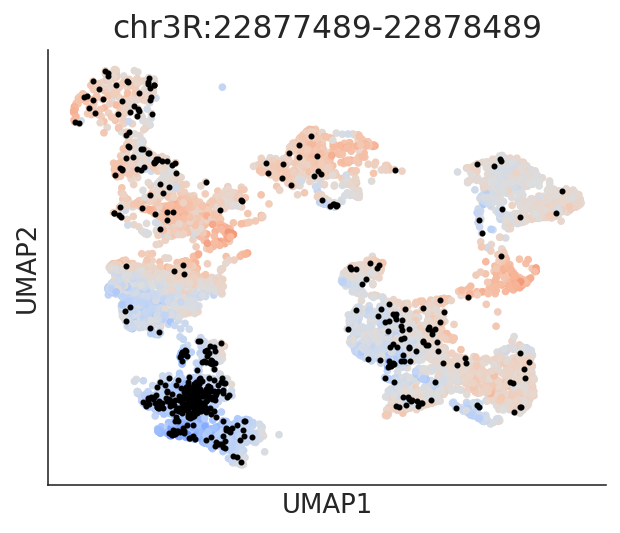

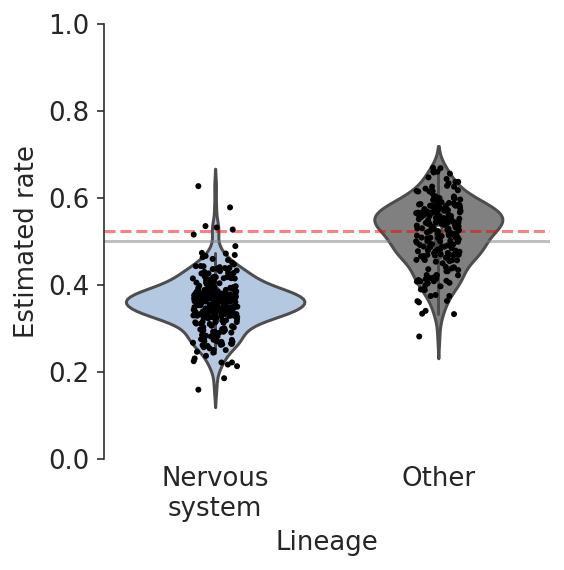

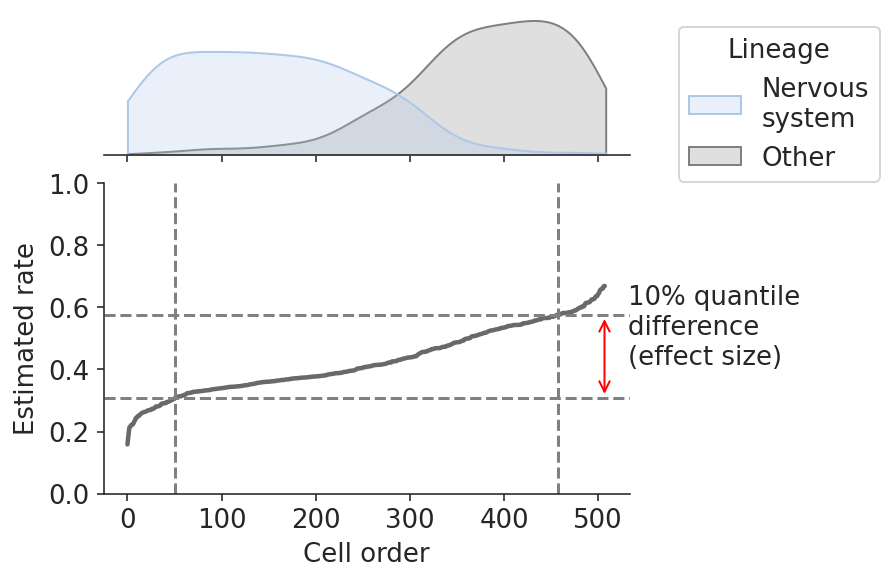

In [19]:
exp_id = 'SS157'
peak = 'chr3R_22877489_22878489'

plot_peak(exp_id, peak, 1)
adatas_allelic[exp_id][:, peak].var[[DALIHET_PVAL + '_bh', DALIHOM_PVAL + '_bh', DALIJOINT_PVAL + '_bh', 'qdiff_10', 'gp_mean']]

In [20]:
adatas_allelic[exp_id][adatas_allelic[exp_id][:, peak].layers['allelic_total'] > 0, :].obs['annotation'].value_counts()

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Nervous system    286
Muscle             83
Primordium         80
Epidermis          25
Midgut             22
Hemocytes           8
Fat body            4
Name: annotation, dtype: int64

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be 

,DALIHET_VAE_bh,DALIHOM_bh,DALIJOINT_bh,qdiff_10,gp_mean
chr2R_13675707_13676707,1.503463e-08,5.529730e-08,2.031988e-15,0.287944,0.605541


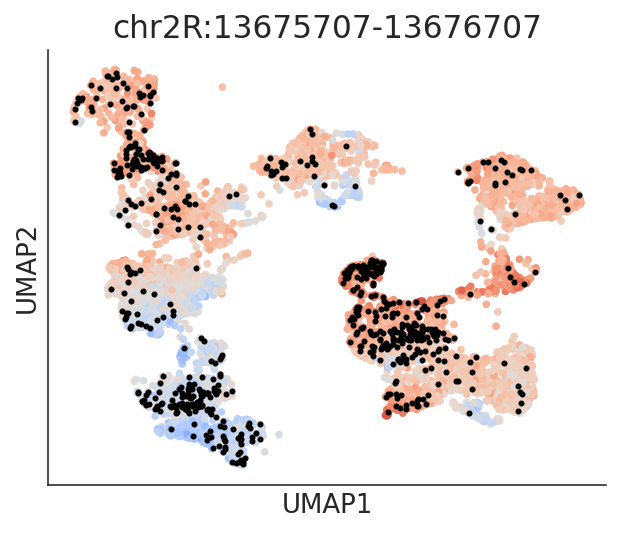

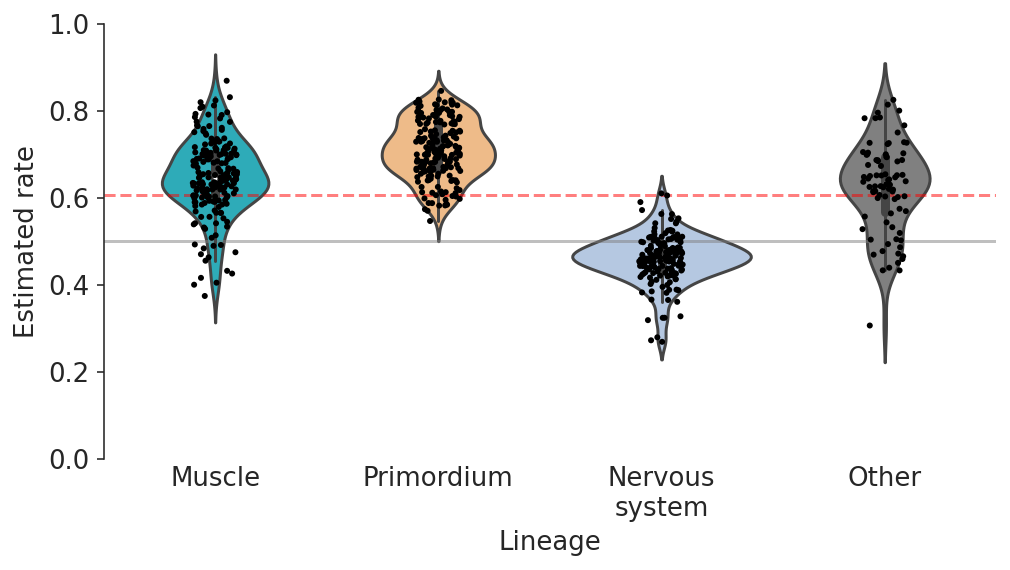

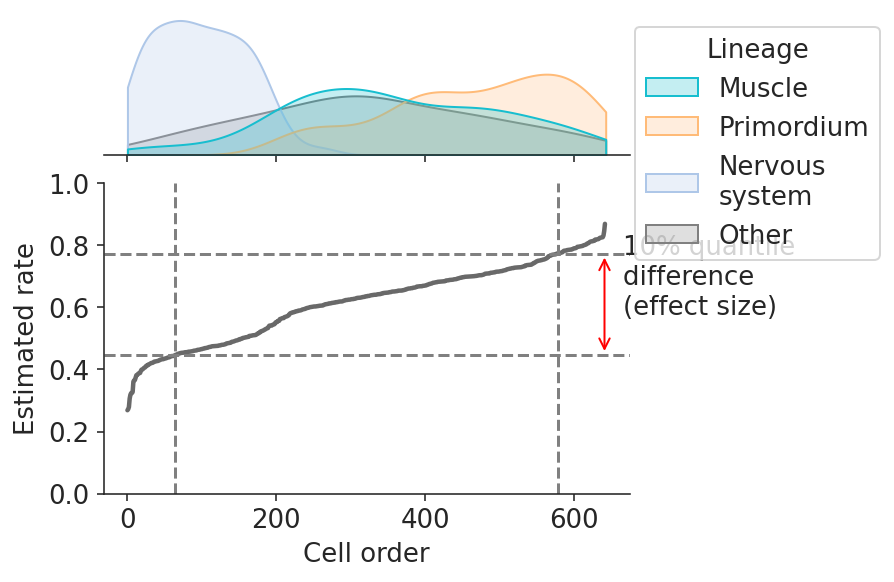

In [21]:
exp_id = 'SS157'
peak = 'chr2R_13675707_13676707'

plot_peak(exp_id, peak, 3)
adatas_allelic[exp_id][:, peak].var[[DALIHET_PVAL + '_bh', DALIHOM_PVAL + '_bh', DALIJOINT_PVAL + '_bh', 'qdiff_10', 'gp_mean']]

In [22]:
adatas_allelic[exp_id][adatas_allelic[exp_id][:, peak].layers['allelic_total'] > 0, :].obs['annotation'].value_counts()

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Muscle            200
Primordium        195
Nervous system    164
Midgut             26
Epidermis          26
Hemocytes          24
Fat body            8
Name: annotation, dtype: int64

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be 

,DALIHET_VAE_bh,DALIHOM_bh,DALIJOINT_bh,qdiff_10,gp_mean
chr3R_20310056_20311056,5.446907e-08,0.811527,1.928219e-08,0.316943,0.470333


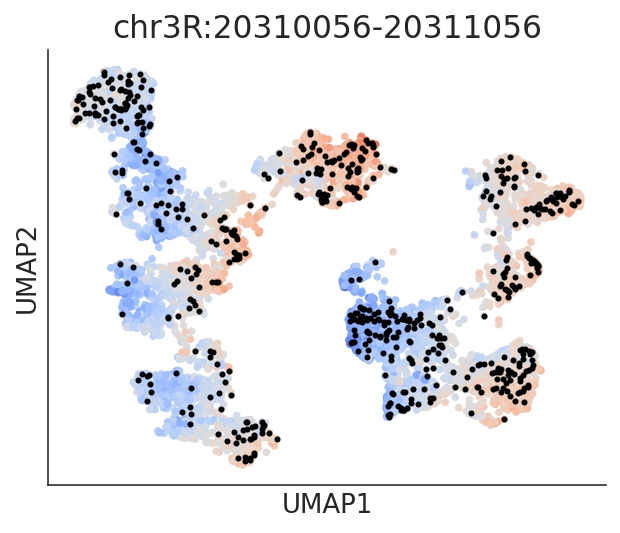

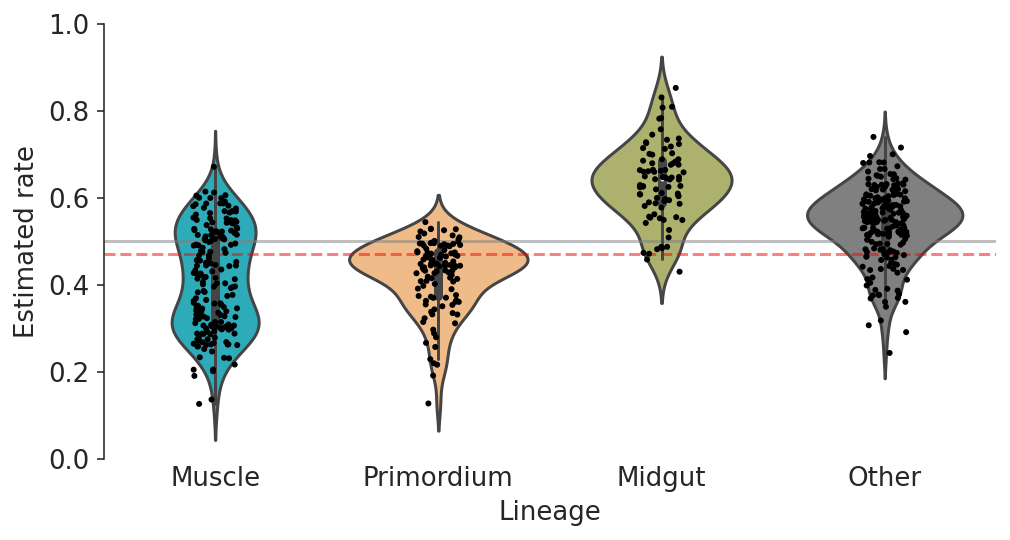

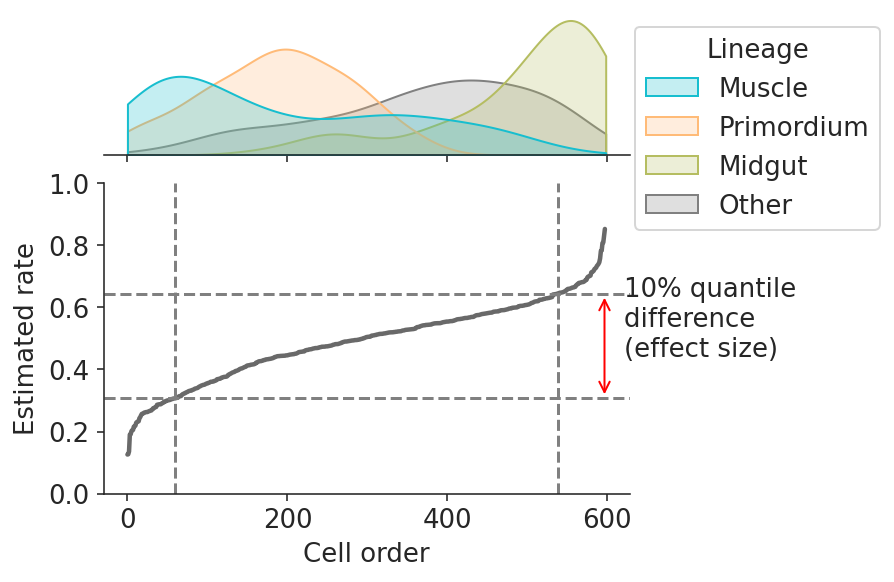

In [23]:
exp_id = 'SS159'
peak = 'chr3R_20310056_20311056'

plot_peak(exp_id, peak, 3)
adatas_allelic[exp_id][:, peak].var[[DALIHET_PVAL + '_bh', DALIHOM_PVAL + '_bh', DALIJOINT_PVAL + '_bh', 'qdiff_10', 'gp_mean']]

In [24]:
adatas_allelic[exp_id][adatas_allelic[exp_id][:, peak].layers['allelic_total'] > 0, :].obs['annotation'].value_counts()

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Muscle            191
Primordium        112
Midgut             85
Epidermis          67
Hemocytes          59
Nervous system     58
Fat body           26
Name: annotation, dtype: int64

/icgc/dkfzlsdf/analysis/B260/users/heinent/envs/f1_analysis/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


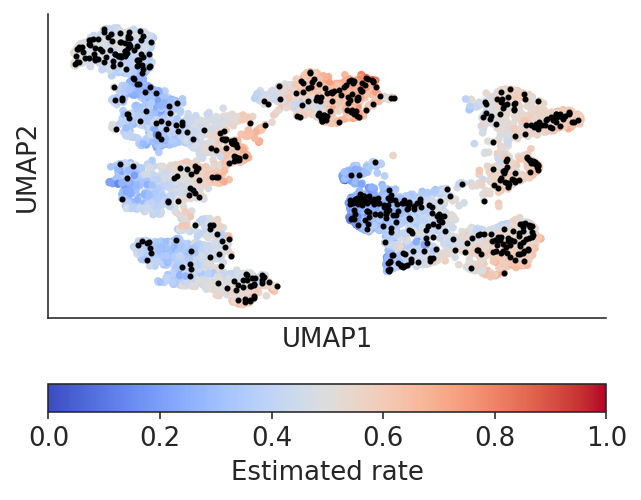

In [25]:
with plt.rc_context({'lines.markersize': 2}):
    exp_id = 'SS159'
    peak = 'chr3R_20310056_20311056'
    adata = adatas_allelic[exp_id]
    fig, ax = plt.subplots(figsize=(5, 4))
    plotting.plot_rate_umap(
        adata=adata,
        peak=peak,
        show_colorbar=True)   
    save_panel(fig)

## CAD4 overlap

In [26]:
tested_counts = df_all['CAD_overlap'].value_counts(sort=False).rename({0: 'No overlap', 1: 'Overlap'})
hom_counts = df_all[df_all['Hom. AI']]['CAD_overlap'].value_counts(sort=False).rename({0: 'No overlap', 1: 'Overlap'})
het_counts = df_all[df_all['Het. AI']]['CAD_overlap'].value_counts(sort=False).rename({0: 'No overlap', 1: 'Overlap'})
onlyhet_counts = df_all[df_all['Only Het. AI']]['CAD_overlap'].value_counts(sort=False).rename({0: 'No overlap', 1: 'Overlap'})

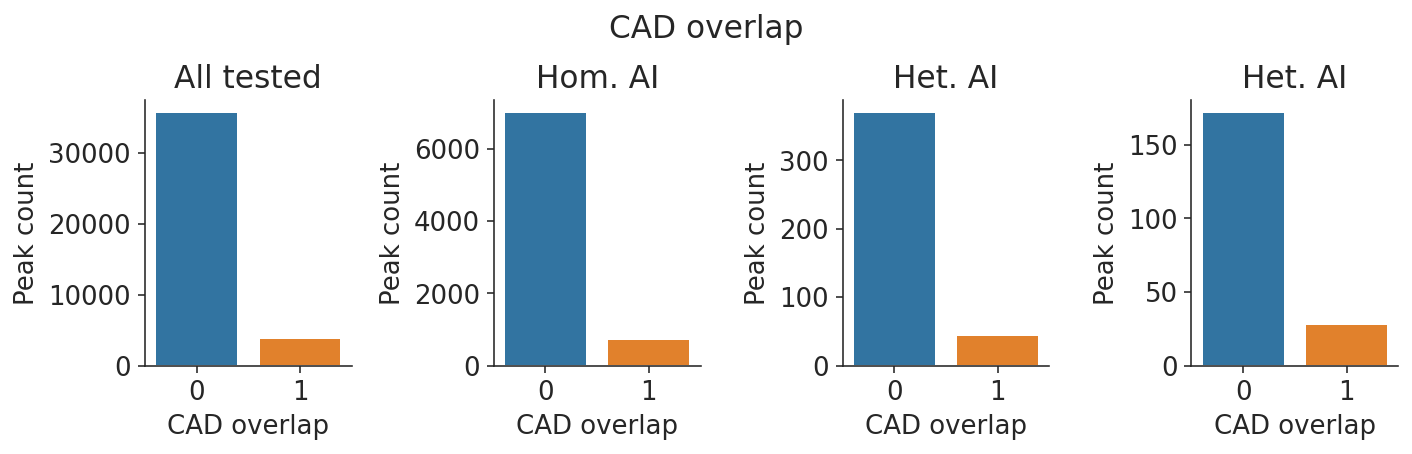

In [27]:
fig, axes = plt.subplots(1, 4, figsize=(10, 3))

ax = axes[0]
sns.countplot(x='CAD_overlap', data=df_all, ax=ax)
ax.set(xlabel='CAD overlap', ylabel='Peak count', title='All tested')

ax = axes[1]
sns.countplot(x='CAD_overlap', data=df_all[df_all['Hom. AI']], ax=ax)
ax.set(xlabel='CAD overlap', ylabel='Peak count', title='Hom. AI')

ax = axes[2]
sns.countplot(x='CAD_overlap', data=df_all[df_all['Het. AI']], ax=ax)
ax.set(xlabel='CAD overlap', ylabel='Peak count', title='Het. AI')

ax = axes[3]
sns.countplot(x='CAD_overlap', data=df_all[df_all['Only Het. AI']], ax=ax)
ax.set(xlabel='CAD overlap', ylabel='Peak count', title='Het. AI')

plt.suptitle('CAD overlap', y=1.05)
plt.tight_layout()
sns.despine()

save_panel(fig)

In [28]:
from scipy.stats import chisquare, chi2_contingency

In [29]:
scipy.stats.binom_test(x=hom_counts['Overlap'], n=hom_counts.sum(), p=tested_counts['Overlap']/tested_counts.sum())

0.22029241908597236

In [30]:
scipy.stats.binom_test(x=het_counts['Overlap'], n=het_counts.sum(), p=tested_counts['Overlap']/tested_counts.sum())

0.45639981497667936

In [31]:
scipy.stats.binom_test(x=onlyhet_counts['Overlap'], n=onlyhet_counts.sum(), p=tested_counts['Overlap']/tested_counts.sum())

0.055302179883256405

## Discoveries by genomic distance

In [32]:
tested_counts = df_all['TSS_1kb_peak'].value_counts(sort=False)
hom_counts = df_all[df_all['Hom. AI']]['TSS_1kb_peak'].value_counts(sort=False)
het_counts = df_all[df_all['Het. AI']]['TSS_1kb_peak'].value_counts(sort=False)

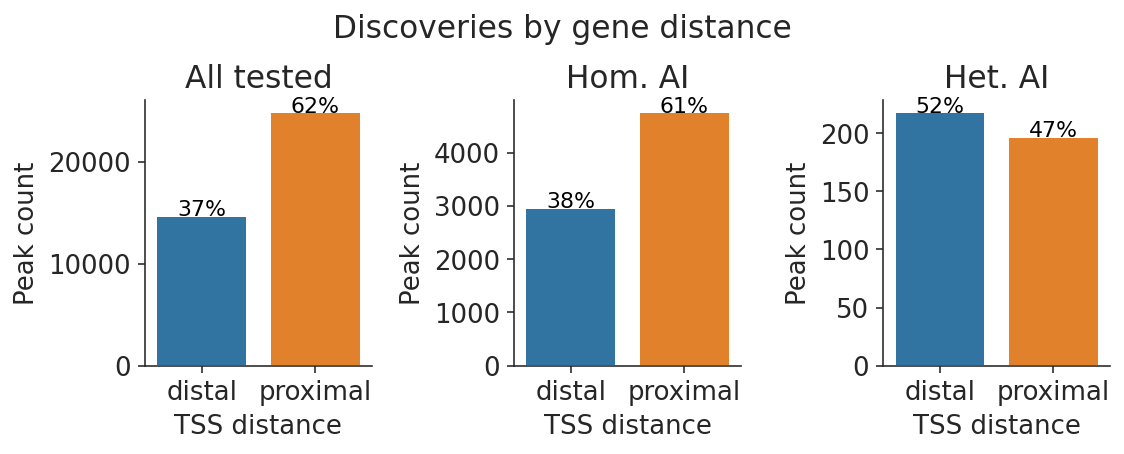

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))

ax = axes[0]
sns.countplot(x='TSS_1kb_peak', data=df_all, ax=ax)
ax.set(xlabel='TSS distance', ylabel='Peak count', title='All tested')
ax.text(0, tested_counts['distal'], '%d%%' % (100 * tested_counts['distal'] / tested_counts.sum()), ha='center', color='black', fontsize=11)
ax.text(1, tested_counts['proximal'], '%d%%' % (100 * tested_counts['proximal'] / tested_counts.sum()), ha='center', color='black', fontsize=11)

ax = axes[1]
sns.countplot(x='TSS_1kb_peak', data=df_all[df_all['Hom. AI']], ax=ax)
ax.set(xlabel='TSS distance', ylabel='Peak count', title='Hom. AI')
ax.text(0, hom_counts['distal'], '%d%%' % (100 * hom_counts['distal'] / hom_counts.sum()), ha='center', color='black', fontsize=11)
ax.text(1, hom_counts['proximal'], '%d%%' % (100 * hom_counts['proximal'] / hom_counts.sum()), ha='center', color='black', fontsize=11)

ax = axes[2]
sns.countplot(x='TSS_1kb_peak', data=df_all[df_all['Het. AI']], ax=ax)
ax.set(xlabel='TSS distance', ylabel='Peak count', title='Het. AI')
ax.text(0, het_counts['distal'], '%d%%' % (100 * het_counts['distal'] / het_counts.sum()), ha='center', color='black', fontsize=11)
ax.text(1, het_counts['proximal'], '%d%%' % (100 * het_counts['proximal'] / het_counts.sum()), ha='center', color='black', fontsize=11)

plt.suptitle('Discoveries by gene distance', y=1.05)
plt.tight_layout()
sns.despine()

save_panel(fig)

In [34]:
from scipy.stats import chisquare, chi2_contingency

In [35]:
scipy.stats.binom_test(x=hom_counts['distal'], n=hom_counts.sum(), p=tested_counts['distal']/tested_counts.sum())

0.019196221656779994

In [36]:
scipy.stats.binom_test(x=het_counts['distal'], n=het_counts.sum(), p=tested_counts['distal']/tested_counts.sum())

2.1531883841975213e-10

## Effect size by genomic distance

In [37]:
df_all['dev'] = np.abs(df_all['base_rate'] - .5)

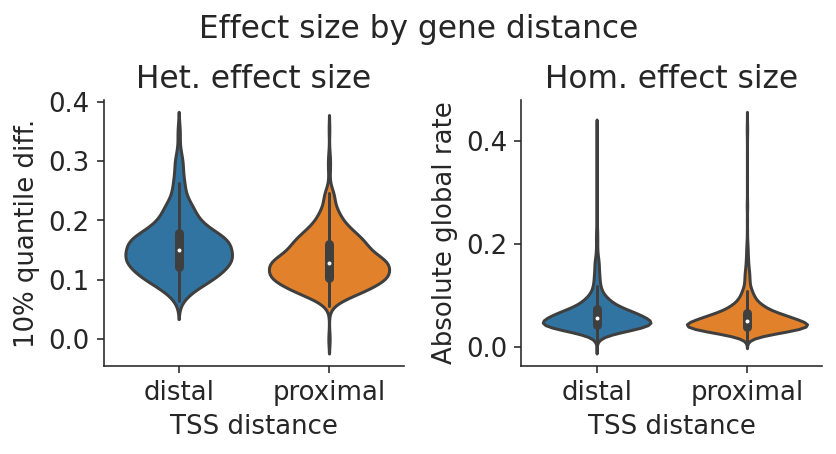

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

ax = axes[0]
sns.violinplot(x='TSS_1kb_peak', y='qdiff_10', data=df_all, ax=ax)
#sns.stripplot(x='TSS_1kb_peak', y='qdiff_10', data=df_all, color='black', s=2, ax=ax)
ax.set(xlabel='TSS distance', ylabel='10% quantile diff.', title='Het. effect size')
ax = axes[1]
sns.violinplot(x='TSS_1kb_peak', y='dev', data=df_all.query(DALIHOM_PVAL + '_bh < .1'), ax=ax)
#sns.stripplot(x='TSS_1kb_peak', y='dev', data=df_all.query(DALIHOM_PVAL + '_bh < .1'), color='black', s=2, ax=ax)
ax.set(xlabel='TSS distance', ylabel='Absolute global rate',  title='Hom. effect size')

plt.suptitle('Effect size by gene distance', y=1.05)
plt.tight_layout()
sns.despine()
save_panel(fig)

In [39]:
from scipy.stats import mannwhitneyu

In [40]:
p_het = mannwhitneyu(
    df_all.query('(TSS_1kb_peak == "distal") and (%s_bh < .1)' % DALIHET_PVAL)['qdiff_10'].to_numpy(),
    df_all.query('(TSS_1kb_peak == "proximal") and (%s_bh < .1)' % DALIHET_PVAL)['qdiff_10'].to_numpy(),
    alternative='greater').pvalue

In [41]:
p_hom = mannwhitneyu(
    df_all.query('(TSS_1kb_peak == "distal") and (%s_bh < .1)' % DALIHOM_PVAL)['dev'].to_numpy(),
    df_all.query('(TSS_1kb_peak == "proximal") and (%s_bh < .1)' % DALIHOM_PVAL)['dev'].to_numpy(),
    alternative='greater').pvalue

In [42]:
p_het, p_hom

(5.599864585669462e-05, 2.1687630112028793e-26)

In [43]:
x=

SyntaxError: invalid syntax (<ipython-input-43-d2686eb1c575>, line 1)